# Times series forecasting weather

Horst Stein, T-Labs, May 2020

## 1 Overview

The goal of this notebook is to explore time-series prediction methods with neural nets for an federated Learning approach. 
Two data sets from different locations Jena and Saale from 2009 to 2016 are used to train a nn for prediction and apply the results in form of a model to the other data set.
The idea is to verify that 
- Federated learning on two local datasets increases the prediction precision.
- Sequential training results in form of a model on separate data sets, can optimize the evaluation results . 
- The local data are not transfered to the central unit, only the model parameters (weights) are transfered and than aggregated, and transfered to the nodes again for the next local learning phase.


## 2 Import data

Two data sets are explored:
- data of weather data of Jena and Saale on 10 minutes base in .csv files, which cover measurement data of a half year each https://www.bgc-jena.mpg.de/wetter/weather_data.html

## 3 Data Visualization and autocorrelation
Some analysis on the data is performed by visual analysis to identify trends, saisonality.

Review the autocorrelation of the lags.

## 4 Test if data are stationary
This is helpful understand methods which are potentially effectful for time-series prediction.

## 5 Comparison of methods

### 5.1. Neural Network LSTM
A neural network for time series using LSTM /RNN is used.
### 5.2. ARIMA - variants from pmdarima autoarima and statsmodel seasonal arima
AutoRegressive Integrated Moving Average with eXogenous regressors model. Just remember that it is composed of several statistical models and is highly configurable.
    




# Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt

#plt.style.use('fivethirtyeight')
#print(os.listdir("../input"))
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
#from fbprophet import Prophet
#import xgboost as xgb
#import lightgbm as lgb
#import sklearn.gaussian_process as gp
import seaborn as sns
import timeit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from timeit import default_timer as timer
from datetime import timedelta
import glob

import tensorflow as tf
print('tensorflow', tf.__version__)
import keras
keras.__version__


tensorflow 2.1.0


Using TensorFlow backend.


'2.3.1'

In [2]:
def split_data(data, split_date):
    
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

# Choose data_source

In [3]:
data_source = 'weather_jena'
data_source = 'weather_saale'

# Import weather data Saale and Jena

In [4]:
#import glob
if data_source == 'weather_saale':
    path = r'data/data_saale' # use your path
if data_source == 'weather_jena':
    path = r'data/data_jena'
print ('reading weather data of',data_source)
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    print('reading file .',filename)
    df = pd.read_csv(filename,index_col='Date Time',parse_dates = ['Date Time'], encoding = "ISO-8859-1")
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=False)
df.shape

reading weather data of weather_saale
reading file . data/data_saale\mpi_saale_2009a.csv
reading file . data/data_saale\mpi_saale_2009b.csv
reading file . data/data_saale\mpi_saale_2010a.csv
reading file . data/data_saale\mpi_saale_2010b.csv
reading file . data/data_saale\mpi_saale_2011a.csv
reading file . data/data_saale\mpi_saale_2011b.csv
reading file . data/data_saale\mpi_saale_2012a.csv
reading file . data/data_saale\mpi_saale_2012b.csv
reading file . data/data_saale\mpi_saale_2013a.csv
reading file . data/data_saale\mpi_saale_2013b.csv
reading file . data/data_saale\mpi_saale_2014a.csv
reading file . data/data_saale\mpi_saale_2014b.csv
reading file . data/data_saale\mpi_saale_2015a.csv
reading file . data/data_saale\mpi_saale_2015b.csv
reading file . data/data_saale\mpi_saale_2016a.csv
reading file . data/data_saale\mpi_saale_2016b.csv


(419515, 30)

In [5]:
target = 'T (degC)'
df.describe()

p (mbar)       T (degC)         rh (%)      sh (g/kg)  \
count  419515.000000  419515.000000  419515.000000  419515.000000   
mean      993.758594       4.274341      65.560890     -16.928709   
std       251.947925     231.364466     366.134486     481.051719   
min     -9999.000000   -9999.000000   -9999.000000   -9999.000000   
25%       994.420000       3.675000      67.090000       4.010000   
50%       999.900000       9.440000      83.000000       5.750000   
75%      1005.140000      15.480000      95.000000       8.140000   
max      1026.020000      37.910000     100.000000      19.250000   

            Tpot (K)    Tdew (degC)   VPmax (mbar)   VPact (mbar)  \
count  419515.000000  419515.000000  419515.000000  419515.000000   
mean      272.038170     -17.944773       8.387143      -8.185561   
std       332.917545     483.529879     231.441656     426.210503   
min     -9999.000000   -9999.000000   -9999.000000   -9999.000000   
25%       276.890000       0.710000       7.950000       6.430000   
50%       282.690000       5.760000      11.840000       9.200000   
75%       288.720000      10.850000      17.610000      13.010000   
max       310.980000      24.280000      65.990000      30.380000   

        VPdef (mbar)  H2OC (mmol/mol)  ...   ST008 (degC)   ST016 (degC)  \
count  419515.000000    419515.000000  ...  419515.000000  419515.000000   
mean      -14.424946       -13.183088  ...      10.504746      10.655317   
std       425.953576       481.245005  ...      41.471748      41.407632   
min     -9999.000000     -9999.000000  ...   -9999.000000   -9999.000000   
25%         0.410000         6.440000  ...       4.440000       4.850000   
50%         1.650000         9.210000  ...      10.530000      10.700000   
75%         4.740000        13.020000  ...      16.540000      16.590000   
max        51.770000        30.600000  ...      31.830000      27.800000   

        ST032 (degC)   ST064 (degC)   ST128 (degC)      SM008 (%)  \
count  419515.000000  419515.000000  419515.000000  419515.000000   
mean       10.641261      10.706773      10.632844      28.727172   
std        41.316809      41.183641      41.032496      49.450893   
min     -9999.000000   -9999.000000   -9999.000000   -9999.000000   
25%         5.300000       6.190000       7.710000      22.960000   
50%        10.680000      10.750000      10.760000      30.140000   
75%        16.240000      15.550000      14.110000      34.360000   
max        53.570000      20.440000      23.510000      50.400000   

           SM016 (%)      SM032 (%)      SM064 (%)      SM128 (%)  
count  419515.000000  419515.000000  419515.000000  419515.000000  
mean       28.091416      29.597823      29.780445      33.473797  
std        49.413783      49.343235      46.736619      49.046795  
min     -9999.000000   -9999.000000   -9999.000000   -9999.000000  
25%        22.380000      23.840000      24.900000      32.450000  
50%        30.140000      31.810000      31.300000      33.030000  
75%        33.150000      34.490000      33.510000      34.360000  
max        52.870000      48.230000      48.320000      43.220000  

[8 rows x 30 columns]

# drop missing measurements values -9999

In [6]:
if df[df['T (degC)']==-9999.00].shape[0]>0:
    print (df[df['T (degC)']==-9999.00].shape[0],'missing values will be dropped')
    df = df.drop(df[df['T (degC)']==-9999.00].index)
    print (df.shape, df[df['T (degC)']==-9999.00].shape)
df.describe()

224 missing values will be dropped
(419291, 30) (0, 30)


p (mbar)       T (degC)         rh (%)      sh (g/kg)  \
count  419291.000000  419291.000000  419291.000000  419291.000000   
mean      993.861087       9.618442      65.926813     -11.595935   
std       249.717485       8.421293     361.250367     422.224695   
min     -9999.000000     -45.030000   -9999.000000   -9999.000000   
25%       994.420000       3.690000      67.110000       4.020000   
50%       999.910000       9.450000      83.000000       5.750000   
75%      1005.140000      15.480000      95.000000       8.140000   
max      1026.020000      37.910000     100.000000      19.250000   

            Tpot (K)    Tdew (degC)   VPmax (mbar)   VPact (mbar)  \
count  419291.000000  419291.000000  419291.000000  419291.000000   
mean      277.525319     -12.612542      13.733441      -2.848116   
std       233.461634     425.060230       7.916437     358.327234   
min     -9999.000000   -9999.000000       0.100000   -9999.000000   
25%       276.900000       0.720000       7.960000       6.440000   
50%       282.690000       5.770000      11.850000       9.210000   
75%       288.720000      10.850000      17.610000      13.010000   
max       310.980000      24.280000      65.990000      30.380000   

        VPdef (mbar)  H2OC (mmol/mol)  ...   ST008 (degC)   ST016 (degC)  \
count  419291.000000    419291.000000  ...  419291.000000  419291.000000   
mean       -9.090835        -7.848314  ...      10.671140      10.822035   
std       358.114459       422.397695  ...       6.937166       6.539107   
min     -9999.000000     -9999.000000  ...      -2.790000      -1.070000   
25%         0.410000         6.440000  ...       4.440000       4.850000   
50%         1.650000         9.210000  ...      10.520000      10.700000   
75%         4.740000        13.020000  ...      16.540000      16.600000   
max        51.770000        30.600000  ...      31.830000      27.800000   

        ST032 (degC)   ST064 (degC)   ST128 (degC)      SM008 (%)  \
count  419291.000000  419291.000000  419291.000000  419291.000000   
mean       10.808278      10.874085      10.800415      28.752624   
std         5.937097       4.922927       3.438906      46.977190   
min         0.290000       1.890000       4.670000   -9999.000000   
25%         5.300000       6.190000       7.710000      22.960000   
50%        10.680000      10.750000      10.770000      30.140000   
75%        16.240000      15.550000      14.120000      34.360000   
max        53.570000      20.440000      23.510000      50.400000   

           SM016 (%)      SM032 (%)      SM064 (%)      SM128 (%)  
count  419291.000000  419291.000000  419291.000000  419291.000000  
mean       28.115611      29.621068      29.778892      33.496968  
std        46.938536      46.863471      46.748991      46.549114  
min     -9999.000000   -9999.000000   -9999.000000   -9999.000000  
25%        22.370000      23.830000      24.900000      32.450000  
50%        30.140000      31.810000      31.300000      33.030000  
75%        33.150000      34.490000      33.510000      34.360000  
max        52.870000      48.230000      48.320000      40.190000  

[8 rows x 30 columns]

# for weather predictions, resample to hour, set start and test 

# set train and test dates

In [7]:
df.sort_index(inplace=True)
start_date = df.head(1).index[0]
end_date = df.tail(1).index[0]
print('Start and end of dataset and shape ',start_date, end_date, df.shape)
    
start_training = '01-01-2010'#'01-01-2009' #'08-01-2016' #03-01-2015
#end_training = '12-31-2012' #'06-30-2016'
#end_training = '12-31-2013' #'06-30-2016'
end_training = '12-31-2014' #'06-30-2016'
start_test = '12-01-2016'
end_test = '12-31-2016' # '04-03-2017' #'04-30-2017' '04-10-2017' '04-02-2017'
print('Start and end of train and test ',start_training, end_training, start_test, end_test)

Start and end of dataset and shape  2009-01-01 00:10:04 2017-01-01 00:00:04 (419291, 30)
Start and end of train and test  01-01-2010 12-31-2014 12-01-2016 12-31-2016


In [8]:
cols = set (df.columns.unique() ) - set(['T (degC)'])
df = df.drop(cols, axis=1)
if df[df.index.duplicated()].shape[0] >0:
    print ( 'shape is ',  df.shape[0])
    df = df[~df.index.duplicated()]
    print ( 'duplicates removed, new shape is ',  df.shape[0])
target = 'T (degC)'
display(df.head(3))

shape is  419291
duplicates removed, new shape is  419253


T (degC)
Date Time                    
2009-01-01 00:10:04     -9.45
2009-01-01 00:20:04     -9.52
2009-01-01 00:30:04     -9.61

# resample from 10 minutes to hours

In [9]:
#df.index = pd.to_datetime(df.index)
df = df.resample('60min').mean()
df.shape

(70129, 1)

In [10]:
print ('number of nans is df' , df.isnull().sum().sum())
df = df.fillna(method='ffill')
print ('number of nans is df' , df.isnull().sum().sum())

number of nans is df 232
number of nans is df 0


In [11]:
df_save = df

In [12]:
df.head(3)

T (degC)
Date Time                    
2009-01-01 00:00:00    -9.640
2009-01-01 01:00:00    -9.645
2009-01-01 02:00:00    -9.995

# Train test split

In [13]:
train = limit(df, start_training, end_training)
test  = limit(df, start_test, end_test)
print (train.shape, test.shape, train.shape[0] + test.shape[0] )
print ('train start', train.index.min(), '\ntrain end  ', train.index.max())
print ('test start ', test.index.min(), '\ntest end   ', test.index.max())

(43800, 1) (720, 1) 44520
train start 2010-01-01 00:00:00 
train end   2014-12-30 23:00:00
test start  2016-12-01 00:00:00 
test end    2016-12-30 23:00:00


In [14]:
display(train.head(1)), type(train)

T (degC)
Date Time           
2010-01-01 -1.161667

(None, pandas.core.frame.DataFrame)

# Define helper functions

In [15]:
#mean_absolute_percentage_error
def MAPE(y_true, y_pred, avoid_NAN = True): 
    # if y_true contains 0, than NAN is returned
    # to avoid NAN, the 0 cases are removed for calculation, if avoid_NAN is True 
    # cast y_true and y_pred to np.array() for all cases
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if avoid_NAN:
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        if list(y_true).count(0) > 0:
            zero_y_true = list(y_true).count(0)
            y_p = []
            y_t = []
            for index, value in enumerate(y_true): 
                if value != 0:
                    #print(index, value) 
                    y_p.append(y_pred[index])
                    y_t.append(y_true[index])
            y_pred = np.array(y_p) 
            y_true = np.array(y_t)
        else:
            zero_y_true = 0
    #avoid_NAN == False
    else:
        zero_y_true = list(y_true).count(0)
    
    #return (np.mean((np.abs(y_true - y_pred)) / (y_true)) * 100), zero_y_true
    return (np.mean((np.abs(y_true - y_pred)) / (y_pred)) * 100), zero_y_true # by FINANCE

In [16]:
pd.options.display.float_format = '{:.2f}'.format
def setup_metric():
    df_metric = pd.DataFrame(index=['MAE','MSE','RMSE','RMSPE','MAPE'])
    df_metric.index.name='Metric'
    return df_metric
df_metric = setup_metric()

def display_metrics (description,y_true, y_pred, display = False):
    # displays metric for case 
    # adds metric to df_metric and returns df_metric
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    rmspe, zeros = root_mean_square_percentage_error(y_true, y_pred, True)
    if zeros > 0: 
        print ('*Warning', zeros, 'zeros removed in y_pred of rmspe')
        rmspe, zeros = root_mean_square_percentage_error(y_true, y_pred, True)
    
    mape, zeros = MAPError(y_true, y_pred)
    if zeros > 0: 
        print ('*Warning', zeros, ' zeros removed in y_true of mape')
        mape, zeros = MAPError(y_true, y_pred, True)
    #print('Results for', description)
    if display:
        print('MAE Mean Absolute Error:', mae)
        print('MSE Mean Squared Error:', mse)  
        print('RMSE Root Mean Squared Error:', rmse)
        print ('RMSPE Root Mean Squared Percentage Error:', rmspe)
        print ('MAPE Mean Absolute Percentage Error:', mape)

    df_metric[description] = [mae,mse,rmse,rmspe,mape ]
    return df_metric

# Visualisation

In [17]:
df.head(3)

T (degC)
Date Time                    
2009-01-01 00:00:00     -9.64
2009-01-01 01:00:00     -9.65
2009-01-01 02:00:00    -10.00

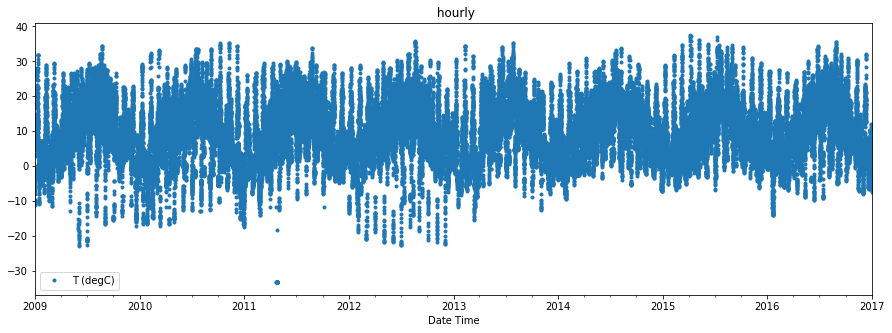

In [18]:
#https://nextjournal.com/blog/plotting-pandas-prophet
pd.plotting.register_matplotlib_converters()
df.plot(style='.', figsize=(15,5), title=' hourly')
plt.show()

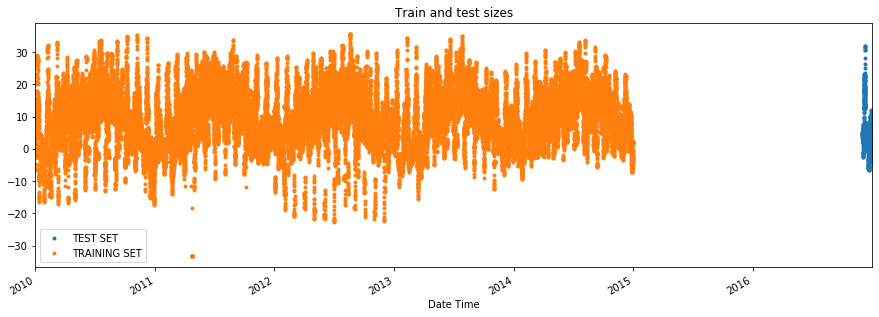

In [19]:
test.rename(columns={target: 'TEST SET'}) \
    .join(train.rename(columns={target: 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Train and test sizes', style='.')
plt.show()

In [20]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date']= df.index
    df.index = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [21]:
X,y = create_features(df, label=target)
df_feature_target = pd.concat([X, y], axis=1)
df_feature_target.head(3)

hour  dayofweek  quarter  month  year  dayofyear  \
Date Time                                                               
2009-01-01 00:00:00     0          3        1      1  2009          1   
2009-01-01 01:00:00     1          3        1      1  2009          1   
2009-01-01 02:00:00     2          3        1      1  2009          1   

                     dayofmonth  weekofyear  T (degC)  
Date Time                                              
2009-01-01 00:00:00           1           1     -9.64  
2009-01-01 01:00:00           1           1     -9.65  
2009-01-01 02:00:00           1           1    -10.00

# show trends and seasonality

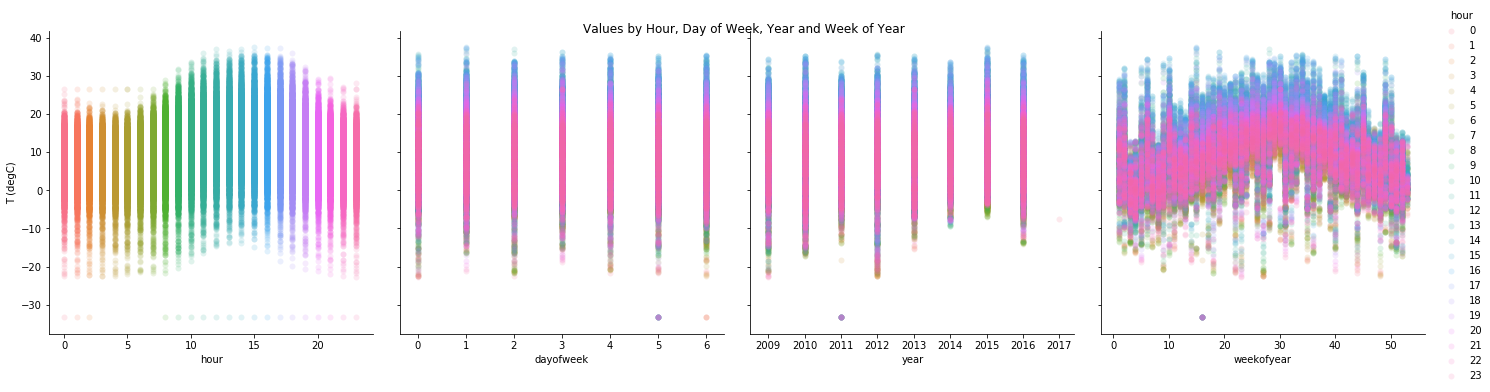

In [22]:
sns.pairplot(df_feature_target,
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars=target,
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Values by Hour, Day of Week, Year and Week of Year')
plt.show()

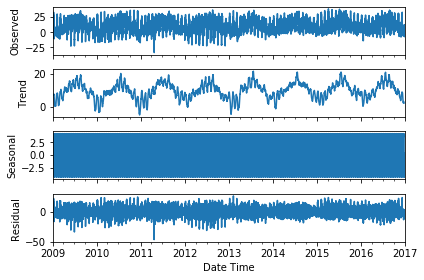

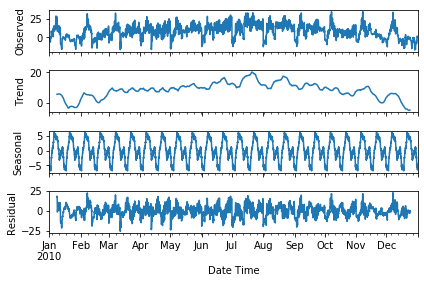

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df[target], model='additive', freq=365)
result.plot()
result = seasonal_decompose(df[target]['2010'], model='additive', freq=365)
result.plot()
pyplot.show()

# Autocorrelation of lags = previous time-periods

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called an autocorrelation plot.

based on https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

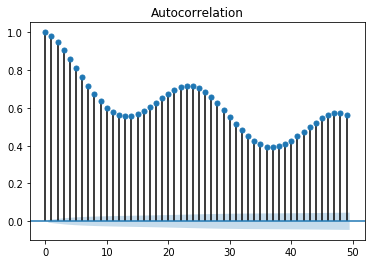

In [24]:
#from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df[target])
pyplot.show()

# Test on stationarity of time series

Statistics of observations are consistent over the dataset,i.e. the time series is stationary.

from https://machinelearningmastery.com/time-series-data-stationary-python/



In [25]:
#from statsmodels.tsa.stattools import adfuller
df_flat = df[target]
adfuller_result = adfuller(df_flat)

In [26]:
print('ADF Statistic: %f' % adfuller_result[0])
print('p-value: %f' % adfuller_result[1])
print('Critical Values:')
for key, value in adfuller_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.817486
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [27]:
if adfuller_result[1] <= 0.05:
    print ('data set is stationary, p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root ')
else:
    print('data set is non-stationary, p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root ')

data set is stationary, p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root 


# Set baseline - Temperature of 24 hours ago

use test data to calculate the past days values - not realistic for periods of forecast, because the values dont exist at forecast time

In [28]:
#del df_base
df_base = df['T (degC)'].reset_index().drop(['Date Time'],axis=1)
df_base['24h_back'] = df_base.shift(24)
df_base['24h_back'] = df_base['24h_back'].fillna(df_base['T (degC)'].mean())
#precondition - test is at the end of the data!!!!
baseline_forecast = df_base.iloc[-test.shape[0]:]['24h_back'].values
#df_base

# Recurrent neural nets, LSTM, multivariate multi-steps

based on 

https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.tensorflow.org/guide/data#time_series_windowing

deeplearning.ai in coursera: Sequences, Time Series and Prediction

https://www.coursera.org/lecture/tensorflow-sequences-time-series-and-prediction/week-4-a-conversation-with-andrew-ng-eFcwn

https://www.coursera.org/lecture/tensorflow-sequences-time-series-and-prediction/conceptual-overview-blByn

https://github.com/MoRebaie/Sequences-Time-Series-Prediction-in-Tensorflow/blob/master/Course_4_Week_4_Exercise_Question.ipynb

In [37]:
start_training,end_training,start_test,end_test 

('01-01-2010', '12-31-2014', '12-01-2016', '12-31-2016')

In [38]:
len(train),len(test),len(train)+len(test)

(43800, 720, 44520)

# scale target to range [0,1]

In [39]:
scaler_m = MinMaxScaler(feature_range=(0, 1))
series =  np.concatenate(( scaler_m.fit_transform(train.values), scaler_m.fit_transform(test.values))).flatten()
time = np.arange(0,len(series))
print('len(series), len(time)',len(series), len(time))
#plt.figure(figsize=(10, 6))
#plot_series(time, series)

len(series), len(time) 44520 44520


In [40]:
split_time = len(train.values)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 2 #6 12 24
batch_size = 32
shuffle_buffer_size = 1000

#print (len(x_train),len(x_valid), split_time, len(train),len(test),len(train_freq),len(test_freq))
#print (x_valid[0], test_freq[0], test[target][test.index.min()])

In [41]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [42]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [43]:
if data_source == 'weather_jena':
    window_size = 2
if data_source == 'weather_saale':
    window_size = 2

In [44]:
# best config by experiments (MAE 0.974 MAPE-128.194), best MAPE(0.96 MAPE 8.279) with batch_size 100
batch_size = 100 # 40
window_size = 2
filters =60
# lambda *400
# lr=1.5e-6

start = timer()
print('rnn training started for',data_source)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=filters, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400) 
])
#optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9) # ==0.000001
optimizer = tf.keras.optimizers.SGD(lr=1.5e-6, momentum=0.9) # ==0.0000015
#optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9) #
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, verbose=0) #150 #30
end = timer()
print('elapsed time in sec ',timedelta(seconds=end-start))

rnn training started for weather_saale
elapsed time in sec  0:16:18.079585


In [301]:
model_path = 'model_'+ str(data_source) + '_ws_'+ str(window_size) + '_bs_'+ str(batch_size) + '_fi_'+ str(filters) 
print('saving ...' ,model_path, 'to', model_path)
model.save(model_path)

saving ... model_weather_saale_ws_2_bs_100_fi_60 to model_weather_saale_ws_2_bs_100_fi_60
INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


# do model forecast and re-scale 

In [45]:
#lr=1.5e-6 batch_size=40 4 years training data_source=saale
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print(rnn_forecast.shape, split_time)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print(rnn_forecast.shape)
rnn_forecast =  scaler_m.inverse_transform (rnn_forecast.reshape(1, -1))
rnn_forecast = rnn_forecast.flatten()
x_valid_ = scaler_m.inverse_transform (x_valid.reshape(1, -1))
y_test = test.values.flatten()
print ('\nScaler MinMax, training start', start_training,end_training, 'test',start_test,end_test, 'window_size', window_size)
print ('Mean Absolute Error and Mean Percentage Error for the methods for data source', data_source)
print ('Method           ','    MAE     ','MAPE')
print ('rnn                 ', mean_absolute_error(y_test, rnn_forecast).round(3), '  ',MAPE(y_test, rnn_forecast)[0].round(3))


(44519, 2, 1) 43800
(720,)

Scaler MinMax, training start 01-01-2010 12-31-2014 test 12-01-2016 12-31-2016 window_size 2
Mean Absolute Error and Mean Percentage Error for the methods for data source weather_saale
Method                MAE      MAPE
rnn                  1.328    9.479


# reload model of jena and predict again

In [46]:
from tensorflow import keras
#reconstructed_model = keras.models.load_model('model_weather_saale_ws_2_bs_100_fi_60')
reconstructed_model = keras.models.load_model('jena_model_bs24_ws2_fi60')
jena_model = reconstructed_model

In [49]:
#lr=1.5e-6 batch_size=40 4 years training data_source=saale
rnn_forecast = model_forecast(reconstructed_model, series[..., np.newaxis], window_size)
print(rnn_forecast.shape, split_time)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print(rnn_forecast.shape)
rnn_forecast =  scaler_m.inverse_transform (rnn_forecast.reshape(1, -1))
rnn_forecast = rnn_forecast.flatten()
x_valid_ = scaler_m.inverse_transform (x_valid.reshape(1, -1))
y_test = test.values.flatten()
print ('\nScaler MinMax, training start', start_training, 'window_size', window_size)
print ('Mean Absolute Error and Mean Percentage Error for the methods for data source', data_source)
print ('Method           ','    MAE     ','MAPE')
print ('rnn                 ', mean_absolute_error(y_test, rnn_forecast).round(3), '  ',MAPE(y_test, rnn_forecast)[0].round(3))


(44519, 2, 1) 43800
(720,)

Scaler MinMax, training start 01-01-2010 window_size 2
Mean Absolute Error and Mean Percentage Error for the methods for data source weather_saale
Method                MAE      MAPE
rnn                  1.081    -2.496


In [50]:
weights_saale = model.get_weights()
print (len(weights_saale[0]), len(weights_saale[0][0]), len(weights_saale[0][0][0]))

5 1 60


In [53]:
weights_jena = jena_model.get_weights()
print (len(weights_jena[0]), len(weights_jena[0][0]), len(weights_jena[0][0][0]))
weights_jena[0][1][0].flatten()

5 1 60


array([-0.00371081,  0.1215644 ,  0.001702  ,  0.0015074 , -0.04179273,
       -0.02302244,  0.13274269,  0.01663421, -0.05989204,  0.1242577 ,
        0.10025716, -0.01509897,  0.03278852,  0.10315259,  0.02951117,
        0.1086252 , -0.04071065, -0.12001118, -0.13237046, -0.03847325,
        0.01146726, -0.01049694,  0.07886153,  0.03791292, -0.01762002,
        0.13861085, -0.10207188, -0.132717  , -0.08353069, -0.08512504,
        0.0161912 ,  0.05763227, -0.00486037,  0.10270222, -0.03584908,
       -0.03260289, -0.08084526, -0.0237613 ,  0.07193859, -0.02713904,
       -0.12293407,  0.13582791, -0.05465558, -0.1338264 ,  0.04684056,
       -0.05121458, -0.06712394,  0.1098363 ,  0.0641748 , -0.01724964,
       -0.02952676,  0.073415  ,  0.09042172,  0.11298333,  0.1189834 ,
       -0.12443446, -0.02464656, -0.06984963,  0.00185475, -0.00060707],
      dtype=float32)

In [375]:
w_aggr = w_jena
l = 1
for layer in model.layers:
    print(l,layer.output_shape, layer)
    #print ('jena', weights_jena)
    #print(len(weights_jena[0][l]))
    w_jena = weights_jena[0][l].flatten()
    w_saale = weights_saale [0][l].flatten()
    #print((w_jena + w_saale)/2)
    w_aggr = (w_jena + w_saale)/2
    print(len(w_aggr),w_aggr)
    l=l+1
    if l==5: break

1 (None, None, 60) <tensorflow.python.keras.layers.convolutional.Conv1D object at 0x00000146B6A34108>
60 [-0.00371081  0.1215644   0.001702    0.0015074  -0.04179273 -0.02302244
  0.13274269  0.01663421 -0.05989204  0.1242577   0.10025716 -0.01509897
  0.03278852  0.10315259  0.02951117  0.1086252  -0.04071065 -0.12001118
 -0.13237046 -0.03847325  0.01146726 -0.01049694  0.07886153  0.03791292
 -0.01762002  0.13861085 -0.10207188 -0.132717   -0.08353069 -0.08512504
  0.0161912   0.05763227 -0.00486037  0.10270222 -0.03584908 -0.03260289
 -0.08084526 -0.0237613   0.07193859 -0.02713904 -0.12293407  0.13582791
 -0.05465558 -0.1338264   0.04684056 -0.05121458 -0.06712394  0.1098363
  0.0641748  -0.01724964 -0.02952676  0.073415    0.09042172  0.11298333
  0.1189834  -0.12443446 -0.02464656 -0.06984963  0.00185475 -0.00060707]
2 (None, None, 60) <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x00000146B74CD0C8>
60 [-0.12714195  0.06713186 -0.04943564 -0.05703527 -0.03831738 -0

In [354]:
weights_jena = reconstructed_model.get_weights()
print (len(weights_jena[0]), len(weights_jena[0][4]), len(weights_jena[0][0][0]))
len(weights_jena[0][4][0])
len(weights_jena[0][2][0])

5 1 60


60

weights_jena

# plot results

In [40]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

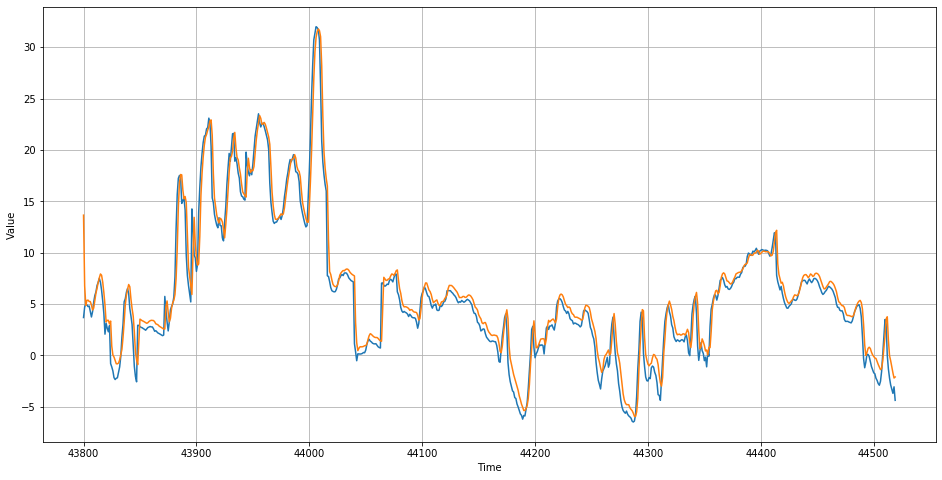

In [41]:
plt.figure(figsize=(16, 8))
plot_series(time_valid, x_valid_.flatten())
plot_series(time_valid, rnn_forecast.flatten())

 ## ARIMA pmd - autoarima
 

In [34]:
#import pyramid
#!pip install pmdarima
#from pmdarima.arima import auto_arima

In [35]:
start = timer()
model_arima = auto_arima(train, trace=True, suppress_warnings=True, error_action='ignore')

preds, conf_int = model_arima.predict(n_periods=test.shape[0], return_conf_int=True)
                                
y_test = test.values.flatten()
y_pred = preds.flatten()
forecast_AutoArima = y_pred
print ('AutoARIMA MAE ',mean_absolute_error(y_test, forecast_AutoArima))
print ('AutoARIMA MAPE', MAPE(y_test, forecast_AutoArima)[0])
end = timer()

print('elapsed time in sec ',timedelta(seconds=end-start))

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=161507.872, BIC=161559.996, Fit time=8.227 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=168152.745, BIC=168170.119, Fit time=0.599 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=161919.188, BIC=161945.250, Fit time=1.721 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=163293.265, BIC=163319.327, Fit time=2.311 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=168150.745, BIC=168159.432, Fit time=0.364 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=161499.778, BIC=161543.214, Fit time=4.772 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=162072.151, BIC=162106.900, Fit time=2.889 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=161506.495, BIC=161541.244, Fit time=3.863 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=161475.845, BIC=161527.969, Fit time=9.673 seconds
F

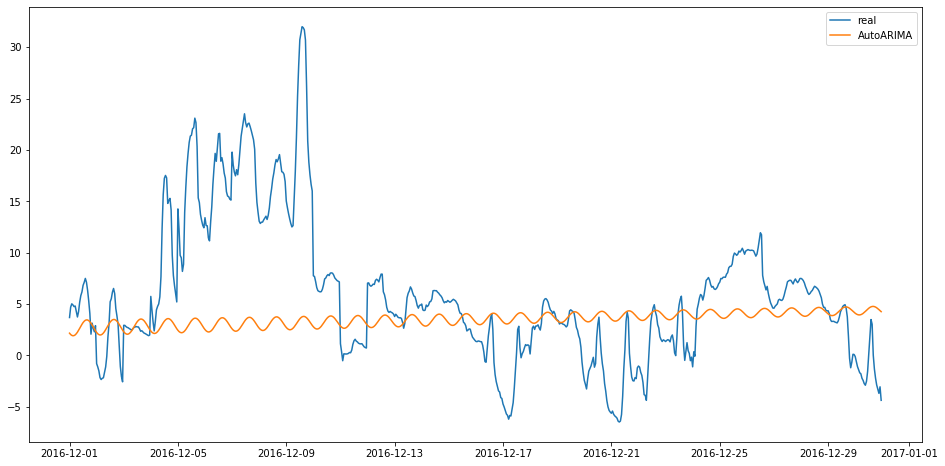

In [36]:
plt.figure(figsize=(16,8))
#plt.plot(pd.concat([train,test]))
plt.plot(pd.concat([test]), label='real' )
plt.plot(test.index, forecast_AutoArima, label='AutoARIMA')
plt.legend()

#  compare error metrics of forecasts 

In [48]:
#lr=1.5e-6 window=12
print ('Mean Absolute Error and Mean Percentage Error for the methods for data source', data_source)
print ('train start - end', start_training, end_training,'test start - end', start_test, end_test)
print ('Method           ','    MAE     ','MAPE')
print ('Baseline 24hours back', mean_absolute_error(y_test, baseline_forecast).round(3), '  ', MAPE(y_test, baseline_forecast)[0].round(3))
print ('LSTM                 ', mean_absolute_error(y_test, rnn_forecast).round(3), \
       '  ',MAPE(y_test, rnn_forecast)[0].round(3))
print ('ARIMA Auto           ', mean_absolute_error(y_test, forecast_AutoArima).round(3), \
       '  ', MAPE(y_test, forecast_AutoArima)[0].round(3))

Mean Absolute Error and Mean Percentage Error for the methods for data source weather_saale
train start - end 01-01-2010 12-31-2014 test start - end 12-01-2016 12-31-2016
Method                MAE      MAPE
Baseline 24hours back 0.648    29.752
LSTM                  1.328    9.479
ARIMA Auto            5.091    154.888
